#### pre-processing

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os
# !pip install ptflops
# from ptflops import get_model_complexity_info
# !pip install wget
# import wget
# !pip install requests gdown
# import gdown

In [ ]:
# Hyper-parameter and setting
image_size = 64
batch_size = 2048
channel_size = 3
lr = 1e-3
num_epochs_student = 10
num_classes = 10

# var init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(123)

In [ ]:
# Data pre-processing of source and target domain
tf_source = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.1307,],  # Normalization as MNIST setting
                        std=[0.30,],
                        )
])

tf_target = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.5, 0.5, 0.5],  # Normalization as default setting
                        std=[0.5, 0.5, 0.5],
                        )
])

########################################################################################
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Dataset and dataloader source & target domain (train_set)
# Ds_source = datasets.MNIST(root='Dataset/mnist_dataset/', download=True, train=True, transform=tf_source)
# Dl_source = DataLoader(Ds_source, batch_size, shuffle=True, num_workers=2)

# Download here: https://drive.google.com/drive/folders/14IgFgyHyJ3I8-VPzzA33sBF1w2E1mVVt?usp=sharing
# Mount and unzip from directory
from google.colab import drive
drive.mount('./drive/')
!unzip './drive/MyDrive/AIoT/MNIST_M.zip'
# Upload directly
# !unzip './MNIST_M.zip'

# Ds_target = datasets.ImageFolder(root='./MNIST_M/train', transform=tf_target)
# Dl_target = DataLoader(Ds_target, batch_size, shuffle=True, num_workers=2)
# train_split = 0.8
# train_size = int(train_split * len(Dl_target))
# test_size = len(Dl_target) - train_size
# Dl_tar_training_set, Dl_tar_testing_set = torch.utils.data.random_split(Dl_target, [train_size, test_size])
Ds_target_train = datasets.ImageFolder(root='./MNIST_M/train', transform=tf_target)
Dl_tar_training_set = DataLoader(Ds_target_train, batch_size, shuffle=True, num_workers=2)
Ds_target_test = datasets.ImageFolder(root='./MNIST_M/test', transform=tf_target)
Dl_tar_testing_set = DataLoader(Ds_target_test, batch_size, shuffle=True, num_workers=2)

def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_student_acc"], label="Train")
    ax1.plot(history["val_student_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_student_loss"], label="Train")
    ax2.plot(history["val_student_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
 extracting: MNIST_M/train/9/00008555.png  
 extracting: MNIST_M/train/9/00008558.png  
 extracting: MNIST_M/train/9/00008563.png  
 extracting: MNIST_M/train/9/00008581.png  
 extracting: MNIST_M/train/9/00008585.png  
 extracting: MNIST_M/train/9/00008586.png  
 extracting: MNIST_M/train/9/00008592.png  
 extracting: MNIST_M/train/9/00008601.png  
 extracting: MNIST_M/train/9/00008608.png  
 extracting: MNIST_M/train/9/00008620.png  
 extracting: MNIST_M/train/9/00008626.png  
 extracting: MNIST_M/train/9/00008630.png  
 extracting: MNIST_M/train/9/00008641.png  
 extracting: MNIST_M/train/9/00008654.png  
 extracting: MNIST_M/train/9/00008669.png  
 extracting: MNIST_M/train/9/00008671.png  
 extracting: MNIST_M/train/9/00008674.png  
 extracting: MNIST_M/train/9/00008702.png  
 extracting: MNIST_M/train/9/00008714.png  
 extracting: MNIST_M/train/9/00008721.png  
 extracting: MNIST_M/train/9/00008736.png  
 extracting: MNIST_

--------------
#### Pruning
Han, S., Mao, H., & Dally, W. J. (2015). Deep compression: Compressing deep neural networks with pruning, trained quantization and huffman coding. arXiv preprint arXiv:1510.00149.\
Referred doc: https://arxiv.org/abs/1510.00149 \
Example: https://github.com/siyuan0/pytorch_model_prune


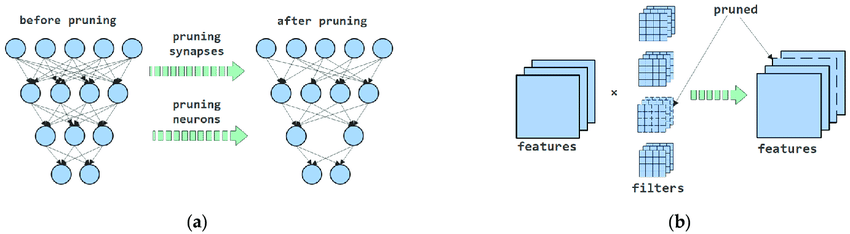

In [ ]:
# @title FLOPS computation
# Code from https://github.com/Eric-mingjie/rethinking-network-pruning/blob/master/imagenet/l1-norm-pruning/compute_flops.py
import numpy as np
import os

import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable


def print_model_param_nums(model=None):
    if model is None:
        raise ValueError("Model cannot be None")
    total = sum([param.nelement() for param in model.parameters()])
    print(f'  + Number of params: {total / 1e6:.4f}M')

def count_model_param_flops(model=None, input_res=224, multiply_adds=True):
    if model is None:
        raise ValueError("Model cannot be None")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    prods = {}
    list_conv = []
    list_linear = []
    list_bn = []
    list_relu = []
    list_pooling = []
    list_upsample = []

    def conv_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()
        kernel_ops = self.kernel_size[0] * self.kernel_size[1] * (self.in_channels / self.groups)
        bias_ops = 1 if self.bias is not None else 0
        params = output_channels * (kernel_ops + bias_ops)
        num_weight_params = (self.weight.data != 0).float().sum()
        flops = (num_weight_params * (2 if multiply_adds else 1) + bias_ops * output_channels) * output_height * output_width * batch_size
        list_conv.append(flops)

    def linear_hook(self, input, output):
        batch_size = input[0].size(0) if input[0].dim() == 2 else 1
        weight_ops = self.weight.nelement() * (2 if multiply_adds else 1)
        bias_ops = self.bias.nelement()
        flops = batch_size * (weight_ops + bias_ops)
        list_linear.append(flops)

    def bn_hook(self, input, output):
        list_bn.append(input[0].nelement() * 2)

    def relu_hook(self, input, output):
        list_relu.append(input[0].nelement())

    def pooling_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()
        kernel_ops = self.kernel_size * self.kernel_size
        bias_ops = 0
        params = 0
        flops = (kernel_ops + bias_ops) * output_channels * output_height * output_width * batch_size
        list_pooling.append(flops)

    def upsample_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()
        flops = output_height * output_width * output_channels * batch_size * 12
        list_upsample.append(flops)

    def register_hooks(net):
        for name, module in net.named_modules():
            if isinstance(module, nn.Conv2d):
                module.register_forward_hook(conv_hook)
            elif isinstance(module, nn.Linear):
                module.register_forward_hook(linear_hook)
            elif isinstance(module, nn.BatchNorm2d):
                module.register_forward_hook(bn_hook)
            elif isinstance(module, nn.ReLU):
                module.register_forward_hook(relu_hook)
            elif isinstance(module, (nn.MaxPool2d, nn.AvgPool2d)):
                module.register_forward_hook(pooling_hook)
            elif isinstance(module, nn.Upsample):
                module.register_forward_hook(upsample_hook)

    register_hooks(model)
    input_tensor = torch.randn(1, 3, input_res, input_res).to(device)
    output = model(input_tensor)

    total_flops = (sum(list_conv) + sum(list_linear) + sum(list_bn) + sum(list_relu) + sum(list_pooling) + sum(list_upsample))
    print(f'Number of FLOPs: {total_flops / 1e9:.6f} GFLOPs ({total_flops / 1e6:.2f} MFLOPs)')

    return total_flops

In [ ]:
# @title Student Model
########################################################################################
import torchvision.models as models
from torchsummary import summary
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class student_model(nn.Module):
    def __init__(self, f=None, C=None, num_classes=10, new_encoder=True, new_classifier=True, class_head=True):
        super(student_model, self).__init__()
        self.in_planes = 64
        self.class_head = class_head
        self.new_encoder = new_encoder

        # Define the ResNet-18 architecture
        if new_encoder:
            self.feature_extractor = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                self._make_layer(BasicBlock, 64, 2, stride=1),
                self._make_layer(BasicBlock, 128, 2, stride=2),
                self._make_layer(BasicBlock, 256, 2, stride=2),
                self._make_layer(BasicBlock, 512, 2, stride=2)
            )
        else:
            self.feature_extractor = f

        self.num_cnn_features = 512 * BasicBlock.expansion

        # Define the classifier
        if new_classifier:
            self.class_classifier = nn.Sequential(
                nn.Flatten(),              # Flatten to (batch_size, 512)
                nn.Linear(self.num_cnn_features, 64),  # First fully connected layer
                nn.ReLU(),                 # Activation function
                nn.Dropout(),              # Dropout for regularization
                nn.Linear(64, num_classes),  # Output layer for classification
                nn.LogSoftmax(dim=1)       # LogSoftmax for output probabilities
            )
        else:
            self.class_classifier = C

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Pass through the feature extractor (should output 4D tensor: [batch_size, channels, height, width])
        features = self.feature_extractor(x)
        # print("Features shape after extractor:", features.shape)  # Should be 4D

        if self.class_head:
            # Adaptive pooling will reduce the spatial dimensions to 1x1
            features = nn.functional.adaptive_avg_pool2d(features, 1)
            # print("Features shape after adaptive pooling:", features.shape)  # Should be [batch_size, 512, 1, 1]

            # Flatten the output to (batch_size, num_cnn_features)
            features = features.view(features.size(0), -1)
            # print("Features shape after flattening:", features.shape)  # Should be [batch_size, 512]

            # Now pass it through the classifier
            class_prediction = self.class_classifier(features)  # Classification head
            return class_prediction
        else:
            return features






# network
student_fn = student_model(num_classes=num_classes).to(device).eval()

summary(student_fn, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=student_fn.eval(), input_res=224, multiply_adds=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7           [-1, 64, 16, 16]          36,864
       BatchNorm2d-8           [-1, 64, 16, 16]             128
        BasicBlock-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,864
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
       BasicBlock-14           [-1, 64,

tensor(3.6348e+09, device='cuda:0')

#### Unpruned student net f at layer[0]

In [ ]:
f = student_fn.feature_extractor
C = student_fn.class_classifier

# Assume need to prune indexing at layer[0]
print(f'all params in f[0]: {list(f[0].named_parameters())}'
      f'\n\n\n buffer in f[0]: {list(f[0].named_buffers())}'
      f'\n\n\n weights in f[0]: {list(f[0].weight)}'
      )

student_fn_unpruned = student_model(f=f, C=C, n_C=num_classes, new_encoder=False, new_classifier=False).to(device)
summary(student_fn_unpruned, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=student_fn_unpruned.eval(), input_res=28, multiply_adds=True)

all params in f[0]: [('weight', Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
    

tensor(68690888., device='cuda:0')

#### Unstructured pruning f at layer[0]

In [ ]:
# @title RamdomUnstructured --> Weight pruned
"""
To prune a module (in this example, the conv1 layer of our LeNet architecture),
first select a pruning technique among those available in torch.nn.utils.prune
(or implement your own by subclassing BasePruningMethod). Then, specify the module
and the name of the parameter to prune within that module. Finally, using
the adequate keyword arguments required by the selected pruning technique,
specify the pruning parameters.

In this example, we will prune at random ***30%*** of the connections in the parameter
named weight in the conv1 layer. The module is passed as the first argument to
the function; name identifies the parameter within that module using its string
identifier; and amount indicates either the percentage of connections to prune
(if it is a float between 0. and 1.), or the absolute number of connections
to prune (if it is a non-negative integer).
"""

import torch.nn.utils.prune as prune
import copy
# Assume prune layer[0] ---> nn.Conv2d(3, 32, kernel_size = 5)
f_pruned = copy.deepcopy(f)

prune.random_unstructured(f_pruned[0], name="weight", amount=0.3)

print(f'all params in f[0]: {list(f_pruned[0].named_parameters())}'
      f'\n\n\n buffer in f[0]: {list(f_pruned[0].named_buffers())}'
      f'\n\n\n weights in f[0]: {f_pruned[0].weight}'
      f'\n\n\n what is pruning in f[0]: {f_pruned[0]._forward_pre_hooks}'
      )

student_fn_pruned = student_model(f=f_pruned, C=C, n_C=num_classes, new_encoder=False, new_classifier=False).to(device)
summary(student_fn_pruned, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=student_fn_pruned.eval(), input_res=28, multiply_adds=True)

all params in f[0]: [('bias', Parameter containing:
tensor([-0.0817, -0.0224, -0.0415,  0.0780, -0.0780,  0.0411, -0.0850,  0.0080,
         0.0666, -0.0742,  0.0333,  0.0669,  0.0671,  0.0096,  0.0674,  0.0096,
         0.1036,  0.1123,  0.0589, -0.0222, -0.0665, -0.0264, -0.0325,  0.1059,
         0.0890,  0.0827,  0.0050, -0.0326,  0.0879,  0.0104, -0.0843, -0.0478],
       requires_grad=True)), ('weight_orig', Parameter containing:
tensor([[[[ 1.0431e-01, -5.5908e-02,  5.4623e-02, -8.9962e-02, -8.7788e-02],
          [-5.0892e-02,  1.1101e-01, -8.5539e-02,  6.9737e-02,  4.6650e-02],
          [-2.4711e-02,  1.1204e-02,  5.6841e-03,  3.9980e-02, -1.1126e-01],
          [-2.0150e-02,  4.5515e-02, -8.5254e-02, -5.6400e-02,  2.7994e-02],
          [ 1.0633e-01, -4.4337e-04, -7.3131e-02,  1.0659e-01,  6.7129e-02]],

         [[ 5.6639e-02,  6.4374e-02,  5.2278e-02, -1.0135e-01, -1.3951e-02],
          [-2.5795e-02, -2.2449e-02, -3.3899e-02,  2.5891e-02,  1.1067e-01],
          [-3.2690e

tensor(8717194.)

In [ ]:
# @title Bias pruned
"""
For completeness, we can now prune the bias too, to see how the parameters,
buffers, hooks, and attributes of the module change. Just for the sake of
trying out another pruning technique, here we prune the 3 smallest entries
in the bias by L1 norm, as implemented in the l1_unstructured pruning function.
"""
# f_l1_pruned = copy.deepcopy(f)

prune.l1_unstructured(f_pruned[0], name="bias", amount=3)

print(f'all params in f[0]: {list(f_pruned[0].named_parameters())}'
      f'\n\n\n buffer in f[0]: {list(f_pruned[0].named_buffers())}'
      f'\n\n\n bias in f[0]: {f_pruned[0].bias}'
      f'\n\n\n what is pruning in f[0]: {f_pruned[0]._forward_pre_hooks}'
      )

student_fn_pruned = student_model(f=f_pruned, C=C, n_C=num_classes, new_encoder=False, new_classifier=False).to(device)
summary(student_fn_pruned, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=student_fn_pruned, input_res=28, multiply_adds=True)

all params in f[0]: [('weight_orig', Parameter containing:
tensor([[[[ 1.0431e-01, -5.5908e-02,  5.4623e-02, -8.9962e-02, -8.7788e-02],
          [-5.0892e-02,  1.1101e-01, -8.5539e-02,  6.9737e-02,  4.6650e-02],
          [-2.4711e-02,  1.1204e-02,  5.6841e-03,  3.9980e-02, -1.1126e-01],
          [-2.0150e-02,  4.5515e-02, -8.5254e-02, -5.6400e-02,  2.7994e-02],
          [ 1.0633e-01, -4.4337e-04, -7.3131e-02,  1.0659e-01,  6.7129e-02]],

         [[ 5.6639e-02,  6.4374e-02,  5.2278e-02, -1.0135e-01, -1.3951e-02],
          [-2.5795e-02, -2.2449e-02, -3.3899e-02,  2.5891e-02,  1.1067e-01],
          [-3.2690e-02, -5.3067e-02,  3.6793e-02, -2.5895e-03, -4.1387e-02],
          [-4.6816e-04,  1.1125e-01,  9.3600e-02, -1.0845e-01, -7.6738e-02],
          [ 1.0416e-01,  3.0197e-02, -1.0085e-01,  9.4375e-03,  1.0365e-01]],

         [[ 7.0574e-03, -4.9101e-02, -7.7293e-02,  6.3092e-03, -1.0178e-01],
          [ 6.3017e-02,  2.5094e-05,  2.2998e-03, -2.6701e-02,  1.8838e-02],
          [ 5

tensor(8717194.)

#### Iterative pruning

In [ ]:
"""
The same parameter in a module can be pruned multiple times, with the effect of
the various pruning calls being equal to the combination of the various masks
applied in series. The combination of a new mask with the old mask is handled
by the PruningContainer’s compute_mask method.

Say, for example, that we now want to further prune module.weight, this time
using structured pruning along the 0th axis of the tensor (the 0th axis
corresponds to the output channels of the convolutional layer and has
dimensionality 6 for conv1), based on the channels’ L2 norm. This can be
achieved using the ln_structured function, with n=2 and dim=0.
"""
# Likewise, prune layer[0] ---> nn.Conv2d(3, 32, kernel_size = 5)
f_iterpruned = copy.deepcopy(f)

prune.ln_structured(f_iterpruned[0], name="weight", amount=0.3, n=2, dim=0)

# As we can verify, this will zero out all the connections corresponding to
# 30% (~2 out of 6) of the channels, while preserving the action of the
# previous mask.
# for hook in f_iterpruned[0]._forward_pre_hooks.values():
#     if hook._tensor_name == "weight":  # select out the correct hook
#         break
print(f'\n\n\n weight in f[0]: {f_iterpruned[0].weight}'
      f'\n\n\n what is pruning in f[0]: {f_iterpruned[0]._forward_pre_hooks}'
      ) # pruning history in the container

student_fn_iterpruned = student_model(f=f_iterpruned, C=C, n_C=num_classes, new_encoder=False, new_classifier=False).to(device)
summary(student_fn_iterpruned, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=student_fn_iterpruned.eval(), input_res=28, multiply_adds=True)

NameError: name 'copy' is not defined

#### Pruning multiple parameters in a model

In [ ]:
"""
By specifying the desired pruning technique and parameters, we can easily prune
multiple tensors in a network, perhaps according to their type, as we will see
at below.
"""

f_multipruned = copy.deepcopy(f)
for name, module in f_multipruned.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)

print(dict(f_multipruned.named_buffers()).keys())  # to verify that all masks exist

dict_keys(['0.weight_mask', '1.running_mean', '1.running_var', '1.num_batches_tracked', '4.weight_mask', '5.running_mean', '5.running_var', '5.num_batches_tracked'])


#### Global pruning

In [ ]:
"""
So far, we only looked at what is usually referred to as “local” pruning, i.e.,
the practice of pruning tensors in a model one by one, by comparing the
statistics (weight magnitude, activation, gradient, etc.) of each entry
exclusively to the other entries in that tensor. However, a common and perhaps
more powerful technique is to prune the model all at once, by removing
(for example) the lowest 20% of connections across the whole model, instead of
removing the lowest 20% of connections in each layer. This is likely to result
in different pruning percentages per layer. Let’s see how to do that using
global_unstructured from 'torch.nn.utils.prune.'
"""
import copy
import torch.nn.utils.prune as prune

student_fn_globpruned = student_model(num_classes=num_classes).to(device)
f = student_fn_globpruned.feature_extractor
C = student_fn_globpruned.class_classifier
f_allpruned = copy.deepcopy(f)
C_allpruned = copy.deepcopy(C)

parameters_to_prune = (
    # --- example: in case of self.layer
    # (f_allpruned.conv1, 'weight'),
    # (f_allpruned.conv2, 'weight'),
    # (f_allpruned.fc1, 'weight'),
    # (f_allpruned.fc2, 'weight'),
    # (f_allpruned.fc3, 'weight'),
    # --- example: in case of sequential layer
    # (f_allpruned[0], 'weight'),
    # (f_allpruned[4], 'weight'),
    # (C_allpruned[2], 'weight'),
    # (C_allpruned[5], 'weight'),
    (f_allpruned[0], 'weight'),    # Conv2d layer
    (f_allpruned[1], 'weight'),    # BatchNorm2d layer
    (f_allpruned[4][0].conv1, 'weight'),  # Conv2d in the first BasicBlock
    (f_allpruned[4][1].conv1, 'weight'),  # Conv2d in the second BasicBlock
    (f_allpruned[6][0].conv1, 'weight'),  # Conv2d in the third BasicBlock
    (f_allpruned[6][1].conv1, 'weight'),  # Conv2d in the fourth BasicBlock
    (C_allpruned[1], 'weight'),      # Linear layer
)

# Pruning the same setting
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.50,
)



# --- example: in case of self.layer
# print(
#     "Sparsity in conv1.weight: {:.2f}%".format(
#         100. * float(torch.sum(f_allpruned.conv1.weight == 0))
#         / float(f_allpruned.conv1.weight.nelement())
#     )
# )
# print(
#     "Sparsity in conv2.weight: {:.2f}%".format(
#         100. * float(torch.sum(f_allpruned.conv2.weight == 0))
#         / float(f_allpruned.conv2.weight.nelement())
#     )
# )
# print(
#     "Sparsity in fc1.weight: {:.2f}%".format(
#         100. * float(torch.sum(f_allpruned.fc1.weight == 0))
#         / float(f_allpruned.fc1.weight.nelement())
#     )
# )
# print(
#     "Sparsity in fc2.weight: {:.2f}%".format(
#         100. * float(torch.sum(f_allpruned.fc2.weight == 0))
#         / float(f_allpruned.fc2.weight.nelement())
#     )
# )
# print(
#     "Sparsity in fc3.weight: {:.2f}%".format(
#         100. * float(torch.sum(f_allpruned.fc3.weight == 0))
#         / float(f_allpruned.fc3.weight.nelement())
#     )
# )
# print(
#     "Global sparsity: {:.2f}%".format(
#         100. * float(
#             torch.sum(f_allpruned.conv1.weight == 0)
#             + torch.sum(f_allpruned.conv2.weight == 0)
#             + torch.sum(f_allpruned.fc1.weight == 0)
#             + torch.sum(f_allpruned.fc2.weight == 0)
#             + torch.sum(f_allpruned.fc3.weight == 0)
#         )
#         / float(
#             f_allpruned.conv1.weight.nelement()
#             + f_allpruned.conv2.weight.nelement()
#             + f_allpruned.fc1.weight.nelement()
#             + f_allpruned.fc2.weight.nelement()
#             + f_allpruned.fc3.weight.nelement()
#         )
#     )
# )
# --- example: in case of sequential layer
print(
    "Sparsity in f_allpruned.conv[0].weight: {:.2f}%".format(
        100. * float(torch.sum(f_allpruned[0].weight == 0))
        / float(f_allpruned[0].weight.nelement())
    )
)
print(
    "Sparsity in f_allpruned.conv[4].weight: {:.2f}%".format(
        100. * float(torch.sum(f_allpruned[1].weight == 0))
        / float(f_allpruned[1].weight.nelement())
    )
)
print(
    "Sparsity in C_allpruned.linear[0].weight: {:.2f}%".format(
        100. * float(torch.sum(f_allpruned[4][0].conv1.weight == 0))
        / float(f_allpruned[4][0].conv1.weight.nelement())
    )
)
print(
    "Sparsity in C_allpruned.linear[4].weight: {:.2f}%".format(
        100. * float(torch.sum(f_allpruned[4][1].conv1.weight == 0))
        / float(f_allpruned[4][1].conv1.weight.nelement())
    )
)
print(
    "Sparsity in C_allpruned.linear[4].weight: {:.2f}%".format(
        100. * float(torch.sum(f_allpruned[6][0].conv1.weight == 0))
        / float(f_allpruned[6][0].conv1.weight.nelement())
    )
)
print(
    "Sparsity in C_allpruned.linear[4].weight: {:.2f}%".format(
        100. * float(torch.sum(f_allpruned[6][1].conv1.weight == 0))
        / float(f_allpruned[6][1].conv1.weight.nelement())
    )
)
print(
    "Sparsity in C_allpruned.linear[4].weight: {:.2f}%".format(
        100. * float(torch.sum(C_allpruned[1].weight == 0))
        / float(C_allpruned[1].weight.nelement())
    )
)

print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(f_allpruned[0].weight == 0)
            + torch.sum(f_allpruned[1].weight == 0)
            + torch.sum(f_allpruned[4][0].conv1.weight == 0)
            + torch.sum(f_allpruned[4][1].conv1.weight == 0)
            + torch.sum(f_allpruned[6][0].conv1.weight == 0)

            + torch.sum(f_allpruned[6][1].conv1.weight == 0)
            + torch.sum(C_allpruned[1].weight == 0)
        )
        / float(
            f_allpruned[0].weight.nelement()
            + f_allpruned[1].weight.nelement()
            + f_allpruned[4][0].conv1.weight.nelement()
            + f_allpruned[4][1].conv1.weight.nelement()
            + f_allpruned[6][0].conv1.weight.nelement()
            + f_allpruned[6][1].conv1.weight.nelement()
            + C_allpruned[1].weight.nelement()
        )
    )
)

student_fn_globpruned = student_model(f=f_allpruned, C=C_allpruned, num_classes=num_classes, new_encoder=False, new_classifier=False).to(device)
summary(student_fn_globpruned, input_size=(channel_size, image_size, image_size))
count_model_param_flops(model=student_fn_globpruned.eval(), input_res=28, multiply_adds=True)

Sparsity in f_allpruned.conv[0].weight: 14.71%
Sparsity in f_allpruned.conv[4].weight: 0.00%
Sparsity in C_allpruned.linear[0].weight: 29.21%
Sparsity in C_allpruned.linear[4].weight: 29.56%
Sparsity in C_allpruned.linear[4].weight: 41.55%
Sparsity in C_allpruned.linear[4].weight: 58.60%
Sparsity in C_allpruned.linear[4].weight: 27.82%
Global sparsity: 50.00%
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7           [-1, 64, 16, 16]          36,864
       BatchNorm2d-8           [-1, 64, 16, 16]             1

tensor(62252904., device='cuda:0')

#### Student batch running (Non-pruned)

epochs 0001 / 0010
[1/29] student class loss: 2.3446 
[2/29] student class loss: 2.3263 
[3/29] student class loss: 2.2846 
[4/29] student class loss: 2.0891 
[5/29] student class loss: 1.8805 
[6/29] student class loss: 1.6484 
[7/29] student class loss: 1.4600 
[8/29] student class loss: 1.2792 
[9/29] student class loss: 1.1678 
[10/29] student class loss: 1.0130 
[11/29] student class loss: 0.9155 
[12/29] student class loss: 0.7936 
[13/29] student class loss: 0.6887 
[14/29] student class loss: 0.6013 
[15/29] student class loss: 0.5536 
[16/29] student class loss: 0.4944 
[17/29] student class loss: 0.4814 
[18/29] student class loss: 0.4165 
[19/29] student class loss: 0.4079 
[20/29] student class loss: 0.4060 
[21/29] student class loss: 0.3493 
[22/29] student class loss: 0.3412 
[23/29] student class loss: 0.3311 
[24/29] student class loss: 0.3290 
[25/29] student class loss: 0.3322 
[26/29] student class loss: 0.3067 
[27/29] student class loss: 0.2937 
[28/29] student cl

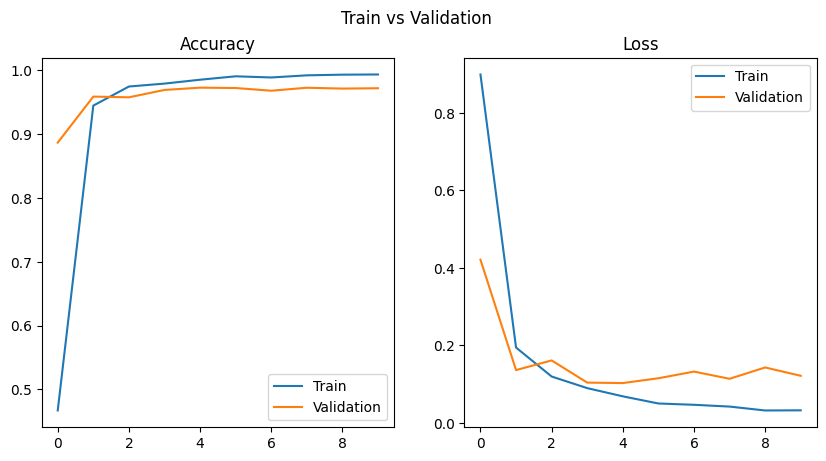

In [ ]:
import torch.optim as optim
# Optimizer and cost function
optimizer = optim.Adam(student_fn.parameters(), lr)
loss_fn = torch.nn.CrossEntropyLoss()

###########################################################################
# 1st step: Training student net
t_0 = time.time()
iter_student = 0
best_vloss = 1_000_000.
training_logs_student = {"train_student_loss": [],  "val_student_loss": [], "train_student_acc": [], "val_student_acc": []}
for epoch in range(num_epochs_student):
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch+1:04d} / {num_epochs_student:04d}', end='\n============\n')

    for i, data in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
        student_fn.train()
        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        X, y = data[0].to(device), data[1].to(device)

        yhat = student_fn(X)
        loss = loss_fn(yhat, y)                 # source classification loss

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        student_fn.eval()
        with torch.no_grad():
          class_prediction = student_fn(X)

        print(f'[{i+1}/{len(Dl_tar_training_set)}] '
              f'student class loss: {loss.item():.4f} '
              )
        # if batch_idx == 50:
        #     print('This is just a demo, stopping...')
        #     break

        train_loss += loss.item()
        train_correct += (class_prediction.argmax(1) == y).float().sum().item()

    training_logs_student["train_student_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs_student["train_student_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    student_fn.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = student_fn(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs_student["val_student_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs_student["val_student_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs_student['train_student_loss'][-1]:.5f}",
            f"train acc {training_logs_student['train_student_acc'][-1]:.5f}",

            f"validate loss {training_logs_student['val_student_loss'][-1]:.5f}",
            f"validate acc {training_logs_student['val_student_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(student_fn.state_dict(), path_save_cp+'best_unpruned_student_model.pth')

    iter_student += 1

t_end = time.time()-t_0
print(f"Time consumption for student net (device:{device}): {t_end} sec")

plot_graph(training_logs_student)

#### Student batch running (Global simple pruned)

epochs 0001 / 0010
[1/29] student class loss: 2.4062 
[2/29] student class loss: 2.3212 
[3/29] student class loss: 2.2172 
[4/29] student class loss: 2.1076 
[5/29] student class loss: 1.8724 
[6/29] student class loss: 1.6512 
[7/29] student class loss: 1.4750 
[8/29] student class loss: 1.3332 
[9/29] student class loss: 1.1137 
[10/29] student class loss: 1.0352 
[11/29] student class loss: 0.8602 
[12/29] student class loss: 0.7790 
[13/29] student class loss: 0.6554 
[14/29] student class loss: 0.5840 
[15/29] student class loss: 0.5686 
[16/29] student class loss: 0.5442 
[17/29] student class loss: 0.4970 
[18/29] student class loss: 0.4486 
[19/29] student class loss: 0.4757 
[20/29] student class loss: 0.4299 
[21/29] student class loss: 0.4153 
[22/29] student class loss: 0.3843 
[23/29] student class loss: 0.3609 
[24/29] student class loss: 0.3542 
[25/29] student class loss: 0.3636 
[26/29] student class loss: 0.3224 
[27/29] student class loss: 0.3323 
[28/29] student cl

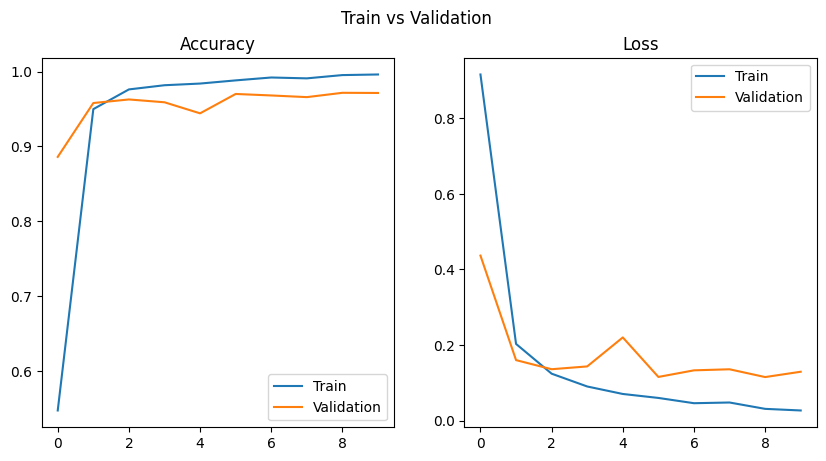

In [ ]:
# Optimizer and cost function
optimizer = optim.Adam(student_fn_globpruned.parameters(), lr)
loss_fn = torch.nn.CrossEntropyLoss()

###########################################################################
# 1st step: Training student net
t_0 = time.time()
iter_student = 0
best_vloss = 1_000_000.
training_logs_student = {"train_student_loss": [],  "val_student_loss": [], "train_student_acc": [], "val_student_acc": []}
for epoch in range(num_epochs_student):
    train_loss, train_correct = 0, 0
    print(f'epochs {epoch+1:04d} / {num_epochs_student:04d}', end='\n============\n')

    for i, data in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
        student_fn_globpruned.train()
        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        X, y = data[0].to(device), data[1].to(device)

        yhat = student_fn_globpruned(X)
        loss = loss_fn(yhat, y)                 # source classification loss

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        student_fn_globpruned.eval()
        with torch.no_grad():
          class_prediction = student_fn_globpruned(X)

        print(f'[{i+1}/{len(Dl_tar_training_set)}] '
              f'student class loss: {loss.item():.4f} '
              )
        # if batch_idx == 50:
        #     print('This is just a demo, stopping...')
        #     break

        train_loss += loss.item()
        train_correct += (class_prediction.argmax(1) == y).float().sum().item()

    training_logs_student["train_student_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs_student["train_student_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    student_fn.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = student_fn_globpruned(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs_student["val_student_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs_student["val_student_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs_student['train_student_loss'][-1]:.5f}",
            f"train acc {training_logs_student['train_student_acc'][-1]:.5f}",

            f"validate loss {training_logs_student['val_student_loss'][-1]:.5f}",
            f"validate acc {training_logs_student['val_student_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(student_fn_globpruned.state_dict(), path_save_cp+'best_pruned_student_model.pth')

    iter_student += 1

t_end = time.time()-t_0
print(f"Time consumption for student net (device:{device}): {t_end} sec")

plot_graph(training_logs_student)

# Summary
Pruning is a technique employed to compress machine learning models by selectively removing parts of the network that are deemed unnecessary. Specifically, it involves cutting away certain neural connections or layers that contribute little to the model's performance. Despite these reductions, pruning helps maintain the model’s overall accuracy and effectiveness, thereby lowering computational requirements and improving efficiency. This approach allows for a leaner, faster model without sacrificing its ability to deliver high-quality results.

# Homework
จงบีบอัดแบบ global pruning ไปยัง ResNet-18 (FLOPs: ~1.8 G) (Referred model in W4-2) โดยบีบอัดที่ระดับ

```
amount = [0.1, 0.3, x]
```
 หมายเหตุ: โดยที่ระดับ x บีบอัดแบบ quantization จน

*   ให้มีประสิทธิภาพความแม่นยำ (%acc) ลดลงได้ไม่เกิน -0.01 % หรือใกล้เคียงเมื่อเปรียบเทียบกับแบบ unpruned student
*   แต่สามารถลดการคำนวณของ FLOPs ลงได้ถึง 2 เท่าหรือใกล้เคียง


 โดยให้ตั้งค่า hyper-parameter ทั้งก่อนและหลังบีบอัดที่ setting เดียวกัน สามารถปรับแต่งอิสระในส่วนของ

*   วิธีการ pruning
*   Layer ที่ทำการ pruning
*   ระดับการ pruning (amount)


```
# Pruning layers (assign by urself)
parameters_to_prune = (
    # --- example: in case of self.layer
    # (f_allpruned.XXXX, 'weight'),
    .
    .
    .
    # (f_allpruned.XXXX, 'weight'),
    # --- example: in case of sequential layer
    (f_allpruned[X], 'weight'),
    .
    .
    .
    (f_allpruned[X], 'weight'),
)

# Pruning structures (assign by urself)
prune.ln_structured(
    parameters_to_prune,
    name="weight",
    amount=XXXXXXXX,  <--- assign by urself
    n=2,
    dim=0)
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.XXXXXXXXX,   <--- assign by urself
    amount=XXXXXXXX,  <--- assign by urself
)
```

จัดส่งเป็น PDF ที่เปรียบเทียบผลระหว่าง unpruned student กับ pruned student แบบต่าง ๆ เปรียบเทียบเชิง

*   Quantitative and visualization results (acc., loss, precision, recall, F1, confusion matrix, etc.)
*   Sparsity in each pruned layer & Global sparsity
*   Computational resource in use (training time, parameters, FLOPs, etc.)
